In [1]:
pip install pandas numpy matplotlib seaborn nltk wordcloud

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/8d/9d/d06860390f9d154fa884f1740a5456378fb153ff57443c91a4a32bab7092/matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for nltk from https://files.pythonhosted.org/packages/4d/66/7d9e26593edda06e8cb531874633f7c2372279c3b0f46235539fe546df8b/nltk-3.9.1-py3-none-any.whl.metadata
  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/90/be/1a7a488f5edcfae6746ffb91e792a1795b6cc058364ea6888b3878d3476f/wordcloud-1.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/99/e6/d1196696

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# NLTK 데이터 다운로드 (처음 한 번만 실행)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /data/ephemeral/home/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /data/ephemeral/home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# CSV 파일로 된 텍스트 데이터 로드 (예: 대화와 요약 데이터)
df = pd.read_csv('/data/ephemeral/home/data/data/test_en.csv')

# 데이터프레임의 처음 몇 줄 확인
df.head(5)

,fname,dialogue,dialogue_en
0,test_400,#Person1#: 안녕하세요. 세입자 지원 센터입니다.#Person2#: 안녕하세...,#Person1#: Hello. This is the Tenant Assistanc...
1,test_401,"#Person1#: 안녕하세요, 여사님. 오늘 어떤 도움을 드릴까요?#Person2...","#Person1#: Hello, ma'am. How can I help you to..."
2,test_402,"#Person1#: 아, 아니야. 찰리, 내 지갑 어디에 있지?#Person2#: ...","#Person1#: Oh, no. Charlie, where's my wallet?..."
3,test_403,#Person1#: 저는 이제 일주일 동안 설거지를 하고 있어요.#Person2#:...,#Person1#: I've been doing the dishes for a we...
4,test_404,"#Person1#: 우리 이야기 좀 할 수 있을까?#Person2#: 그럼, 자기야...","#Person1#: Can we talk?#Person2#: Well, honey,..."


# 마스킹 패턴 찾기

In [3]:
import re
import pandas as pd

def reg_masking(text):
    pattern = r"#\w+#"  # #로 둘러싸인 단어들을 찾는 정규식 패턴
    masked = re.findall(pattern, text)
    return set(masked)  # 중복을 제거하고 고유한 토큰들의 집합을 반환


# `reg_masking`을 호출하고 결과를 문자열로 변환하여 저장
df['masked_patterns'] = df['dialogue_en'].apply(lambda x: str(reg_masking(x)))

# 문자열로 저장된 집합을 실제 집합(set)으로 변환
df['masked_patterns'] = df['masked_patterns'].apply(eval)

# 모든 행에 있는 세트들의 합집합을 구함
all_unique_tokens = set.union(*df['masked_patterns'])

print("고유한 특수 토큰들:", all_unique_tokens)


고유한 특수 토큰들: {'#PassportNumber#', '#Address#', '#Person1#', '#Person2#', '#PhoneNumber#', '#Person3#'}


# dialogue, summary 길이

In [7]:
import re
import pandas as pd

# 제거할 특수 토큰 리스트
special_tokens_all = ['#PassportNumber#', '#Address#', '#Person1#:', '#Person2#:', '#PhoneNumber#', '#Person3#:']
special_tokens_n = ['\n']
special_tokens = ['\n', '#PassportNumber#', '#Address#','#PhoneNumber#']
speaker_tokens = ['#Person1#:', '#Person2#:', '#Person3#:']

# 특수 토큰을 제거하는 함수 정의
def remove_special_tokens(text):
    for token in special_tokens:
        text = text.replace(token, '')  # 특수 토큰을 빈 문자열로 대체
    return text

# 대화의 turn 수를 세는 함수
def count_dialogue_turns(text):
    # 화자 태그 패턴을 정의합니다 (예: #Person1#, #Person2# 등)
    speaker_pattern = r"#Person\d+#"
    
    # 모든 화자 태그를 찾아 리스트로 반환합니다
    speakers = re.findall(speaker_pattern, text)
    
    # 화자가 변경될 때마다 턴을 카운트합니다
    turn_count = 0
    current_speaker = None
    
    for speaker in speakers:
        if speaker != current_speaker:
            turn_count += 1
            current_speaker = speaker
            
    return turn_count

# '\n'을 제거하는 함수 정의
def remove_special_tokens_n(text):
    for token in special_tokens_n:
        text = text.replace(token, '')  # 특수 토큰을 빈 문자열로 대체
    return text

#  제거하는 함수 정의
def remove_speaker_tokens(text):
    for token in speaker_tokens:
        text = text.replace(token, '')  # 특수 토큰을 빈 문자열로 대체
    return text

def count_speakers(text):
    # 화자 식별자에 대한 정규식 패턴 생성
    pattern = r'(' + '|'.join(re.escape(token) for token in speaker_tokens) + ')'
    # 텍스트에서 패턴에 매칭되는 모든 항목을 찾아 집합으로 변환
    speakers = set(re.findall(pattern, text))
    # 집합의 크기(고유 화자 수) 반환
    return len(speakers)

# 대화 및 요약에서 특수 토큰을 제거한 텍스트 생성
df['cleaned_dialogue'] = df['dialogue_en'].apply(remove_special_tokens_n)

# 대화의 turn 수 계산
df['dialogue_turns'] = df['dialogue_en'].apply(count_dialogue_turns)
df['number_of_speakers'] = df['dialogue_en'].apply(count_speakers)

# 텍스트 길이 계산
df['cleaned_dialogue2'] = df['cleaned_dialogue'].apply(remove_speaker_tokens)
df['text_length'] = df['cleaned_dialogue2'].apply(len)

# 텍스트 길이 및 turn 수, 화자 수 통계 출력
print(df[['dialogue_turns', 'number_of_speakers','text_length']].describe())


       dialogue_turns  number_of_speakers  text_length
count      499.000000          499.000000   499.000000
mean         9.685371            2.008016   631.326653
std          4.987455            0.089262   367.059748
min          2.000000            2.000000   147.000000
25%          7.000000            2.000000   366.000000
50%          9.000000            2.000000   557.000000
75%         12.000000            2.000000   795.500000
max         65.000000            3.000000  3457.000000


In [8]:
df[['dialogue_turns', 'number_of_speakers','text_length']].describe()

,dialogue_turns,number_of_speakers,text_length
count,499.000000,499.000000,499.000000
mean,9.685371,2.008016,631.326653
std,4.987455,0.089262,367.059748
min,2.000000,2.000000,147.000000
25%,7.000000,2.000000,366.000000
50%,9.000000,2.000000,557.000000
75%,12.000000,2.000000,795.500000
max,65.000000,3.000000,3457.000000


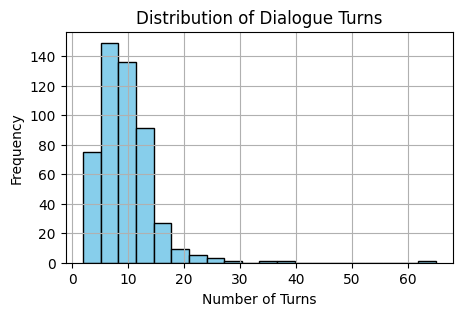

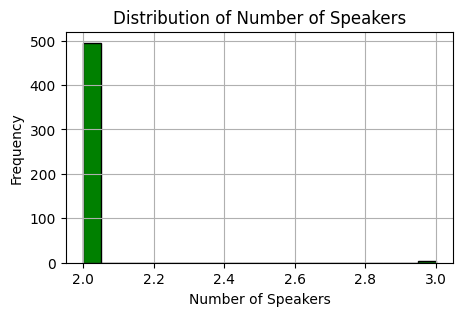

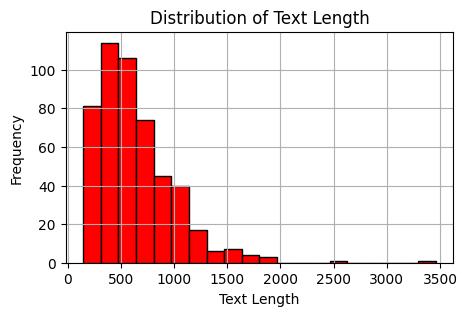

In [9]:
import matplotlib.pyplot as plt

# 'dialogue_turns'의 히스토그램
plt.figure(figsize=(5, 3))
plt.hist(df['dialogue_turns'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Dialogue Turns')
plt.xlabel('Number of Turns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 'number_of_speakers'의 히스토그램
plt.figure(figsize=(5, 3))
plt.hist(df['number_of_speakers'], bins=20, color='green', edgecolor='black')
plt.title('Distribution of Number of Speakers')
plt.xlabel('Number of Speakers')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 'text_length'의 히스토그램
plt.figure(figsize=(5, 3))
plt.hist(df['text_length'], bins=20, color='red', edgecolor='black')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



In [7]:
import pandas as pd

# 출력할 최대 열 수 설정
pd.set_option('display.max_columns', None)

# 출력할 최대 행 수 설정
pd.set_option('display.max_rows', None)

# 첫 번째 행 출력
df.iloc[0]['dialogue']

'#Person1#: 더슨 씨, 받아쓰기 좀 해주세요. \n#Person2#: 네, 실장님...\n#Person1#: 이것은 오늘 오후까지 모든 직원에게 내부 메모로 전달되어야 합니다. 준비되셨나요?\n#Person2#: 네, 실장님. 시작하셔도 됩니다.\n#Person1#: 모든 직원들에게 주의하라... 즉시 효력을 발휘하여, 모든 사무실 통신은 이메일 통신과 공식 메모로 제한됩니다. 근무 시간 동안 직원들이 즉시 메시지 프로그램을 사용하는 것은 엄격히 금지됩니다.\n#Person2#: 실장님, 이것은 내부 통신에만 적용되는 건가요? 아니면 외부 통신에도 제한이 되는 건가요?\n#Person1#: 이것은 모든 통신에 적용되어야 합니다, 이 사무실 내의 직원들 사이뿐만 아니라 외부 통신에도 마찬가지입니다.\n#Person2#: 하지만 실장님, 많은 직원들이 고객과 소통하기 위해 즉시 메시지를 사용하고 있습니다.\n#Person1#: 그들은 그들의 의사소통 방법을 바꾸어야만 합니다. 이 사무실에서 누구도 즉시 메시지를 사용하지 않기를 원합니다. 너무 많은 시간을 낭비하게 됩니다! 이제, 메모를 계속해주세요. 우리가 어디까지 했나요?\n#Person2#: 이것은 내부와 외부 통신에 적용됩니다.\n#Person1#: 그렇습니다. 즉시 메시지를 계속 사용하는 어떤 직원이라도 먼저 경고를 받고 직무 정지에 처해질 것입니다. 두 번째 위반 시에는 직원은 해고에 처해질 것입니다. 이 새로운 정책에 대한 어떤 질문이라도 부서장에게 직접 문의하면 됩니다.\n#Person2#: 그게 다신가요?\n#Person1#: 네. 이 메모를 오후 4시 전에 모든 직원에게 타이핑하여 배포해 주세요.'

In [8]:
df.iloc[1]['cleaned_dialogue2']

' 드디어 왔네! 왜 그렇게 오래 걸렸어? 또 교통 체증에 걸렸어. 까르푸 교차로에서 엄청난 교통 체증이 있었어. 그곳은 출퇴근 시간에 항상 교통이 많이 밀리는 편이야. 집에 가는 다른 길을 찾아 보도록 해.  솔직히 말하면 피할 수 없는 것 같아. 아마 너가 대중교통을 이용하기 시작한다면 더 좋을 것 같아. 그건 고려해봐야 할 것 같아. 대중교통 시스템이 꽤 괜찮아. 환경에도 더 좋을 거야. 알아. 내 차가 이 도시의 오염 문제에 얼마나 기여하고 있는지 나도 느낄 수 있어. 지하철을 타는 것이 운전하는 것보다 훨씬 스트레스를 덜 받을 수 있을 거야. 유일한 문제는 차를 가지고 있는 자유를 정말로 그리워할 것 같다는 거야. 그럼, 날씨가 좋을 때는 자전거로 출근해봐. 그게 너의 차가 주는 자유와 같을 거야. 그게 맞는 말이야. 운동도 좀 해야겠어! 그럼, 너 출근할 때 운전하는 걸 그만두려고 해? 그래, 나에게도 환경에게도 좋지 않아.'

In [10]:
df.head()

,fname,dialogue,masked_patterns,cleaned_dialogue,dialogue_turns,number_of_speakers,cleaned_dialogue2,text_length
0,test_0,"#Person1#: 더슨 씨, 받아쓰기 좀 해주세요. \n#Person2#: 네, ...","{#Person2#, #Person1#}","더슨 씨, 받아쓰기 좀 해주세요. \n 네, 실장님...\n 이것은 오늘 오후까지...",13,2,"더슨 씨, 받아쓰기 좀 해주세요. 네, 실장님... 이것은 오늘 오후까지 모든 ...",679
1,test_1,#Person1#: 드디어 왔네! 왜 그렇게 오래 걸렸어?\n#Person2#: 또...,"{#Person2#, #Person1#}",드디어 왔네! 왜 그렇게 오래 걸렸어?\n 또 교통 체증에 걸렸어. 까르푸 교차로...,14,2,드디어 왔네! 왜 그렇게 오래 걸렸어? 또 교통 체증에 걸렸어. 까르푸 교차로에서...,472
2,test_2,"#Person1#: 케이트, 무슨 일이 일어났는지 너는 믿지 못할거야. \n#Per...","{#Person2#, #Person1#}","케이트, 무슨 일이 일어났는지 너는 믿지 못할거야. \n 어떤 말이야?\n 마샤와...",9,2,"케이트, 무슨 일이 일어났는지 너는 믿지 못할거야. 어떤 말이야? 마샤와 히어로...",383
3,test_3,"#Person1#: 생일 축하해, 이건 너를 위한 거야, 브라이언.\n#Person...","{#Person2#, #Person1#}","생일 축하해, 이건 너를 위한 거야, 브라이언.\n 기억해줘서 너무 행복해, 들어...",9,2,"생일 축하해, 이건 너를 위한 거야, 브라이언. 기억해줘서 너무 행복해, 들어와서...",290
4,test_4,#Person1#: 이 올림픽 공원이 정말 크네요!\n#Person2#: 네. 지금...,"{#Person2#, #Person1#}",이 올림픽 공원이 정말 크네요!\n 네. 지금 우리는 이 공원의 중심인 올림픽 스...,10,2,이 올림픽 공원이 정말 크네요! 네. 지금 우리는 이 공원의 중심인 올림픽 스타디...,280
